# K-Means Demo

KMeans is a basic but powerful clustering method which is optimized via Expectation Maximization. It randomly selects K data points in X, and computes which samples are close to these points. For every cluster of points, a mean is computed, and this becomes the new centroid.

cuML’s KMeans supports the scalable KMeans++ intialization method. This method is more stable than randomnly selecting K points.
    
The model can take array-like objects, either in host as NumPy arrays or in device (as Numba or cuda_array_interface-compliant), as well as cuDF DataFrames as the input.

For information about cuDF, refer to the [cuDF documentation](https://docs.rapids.ai/api/cudf/stable).

For additional information on cuML's k-means implementation: https://docs.rapids.ai/api/cuml/stable/api.html#cuml.KMeans.

## Imports

In [1]:
import cudf
import cupy
try:
    import matplotlib.pyplot as plt
except ImportError:
    !conda install -c conda-forge -y matplotlib
    import matplotlib.pyplot as plt

from cuml.cluster import KMeans as cuKMeans
from cuml.datasets import make_blobs
from sklearn.cluster import KMeans as skKMeans
from sklearn.metrics import adjusted_rand_score

try:
    import matplotlib.pyplot as plt
except ImportError:
    !conda install -c conda-forge -y matplotlib
    import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
try:
    import cuxfilter
except ModuleNotFoundError:
    os.system('conda install -c rapidsai -y cuxfilter')   
import cuxfilter
from cuxfilter.charts import scatter
from cuxfilter import DataFrame, themes, layouts
from cuxfilter.assets.custom_tiles import get_provider, Vendors


## Define Parameters

In [3]:
n_samples = 100000
n_features = 2

n_clusters = 5
random_state = 0

## Generate Data

In [4]:
device_data, device_labels = make_blobs(n_samples=n_samples,
                                        n_features=n_features,
                                        centers=n_clusters,
                                        random_state=random_state,
                                        cluster_std=0.1)

device_data = cudf.DataFrame(device_data)
device_labels = cudf.Series(device_labels)

In [5]:
# Copy dataset from GPU memory to host memory.
# This is done to later compare CPU and GPU results.
host_data = device_data.to_pandas()
host_labels = device_labels.to_pandas()

## Scikit-learn model

### Fit

In [6]:
%%time
kmeans_sk = skKMeans(init="k-means++",
                     n_clusters=n_clusters,
                     n_jobs=-1,
                    random_state=random_state)

kmeans_sk.fit(host_data)

/opt/conda/envs/rapids/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


CPU times: user 4.17 s, sys: 402 ms, total: 4.57 s
Wall time: 702 ms


KMeans(n_clusters=5, n_jobs=-1, random_state=0)

## cuML Model

### Fit

In [7]:
%%time
kmeans_cuml = cuKMeans(init="k-means||",
                       n_clusters=n_clusters,
                       oversampling_factor=40,
                       random_state=random_state)

kmeans_cuml.fit(device_data)

CPU times: user 558 ms, sys: 88.3 ms, total: 646 ms
Wall time: 91.9 ms


KMeans()

## Visualize Centroids

Scikit-learn's k-means implementation uses the `k-means++` initialization strategy while cuML's k-means uses `k-means||`. As a result, the exact centroids found may not be exact as the std deviation of the points around the centroids in `make_blobs` is increased.

*Note*: Visualizing the centroids will only work when `n_features = 2` 

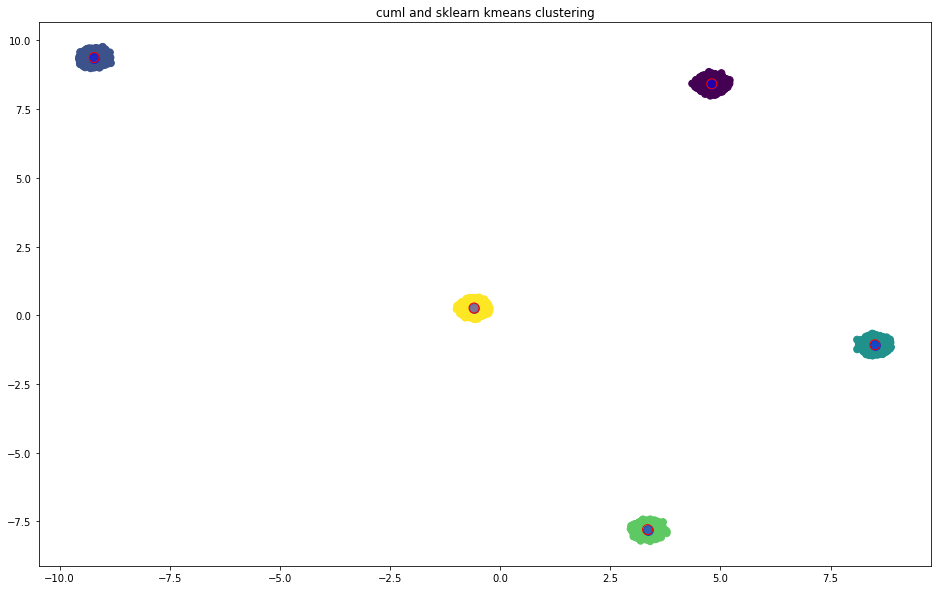

In [8]:
fig = plt.figure(figsize=(16, 10))
plt.scatter(host_data.iloc[:, 0], host_data.iloc[:, 1], c=host_labels, s=50, cmap='viridis')

#plot the sklearn kmeans centers with blue filled circles
centers_sk = kmeans_sk.cluster_centers_
plt.scatter(centers_sk[:,0], centers_sk[:,1], c='blue', s=100, alpha=.5)

#plot the cuml kmeans centers with red circle outlines
centers_cuml = kmeans_cuml.cluster_centers_
plt.scatter(cupy.asnumpy(centers_cuml[0].values), 
            cupy.asnumpy(centers_cuml[1].values), 
            facecolors = 'none', edgecolors='red', s=100)

plt.title('cuml and sklearn kmeans clustering')

plt.show()

We can also now visualize our data using the `cuxfilter` library.

In [9]:
reshaped_df = cudf.DataFrame(host_data)
reshaped_df.columns =['x' , 'y']

print(reshaped_df)

              x         y
0     -9.171562  9.484344
1      8.668811 -1.148119
2      8.506779 -1.072674
3     -0.445039  0.276176
4     -9.203829  9.442251
...         ...       ...
99995  8.547510 -1.194713
99996  4.901207  8.319950
99997  3.182067 -7.943660
99998  4.964210  8.337237
99999  3.194597 -7.864161

[100000 rows x 2 columns]


In [10]:
cux_df = DataFrame.from_dataframe(reshaped_df)
# setting pixel_shade_type='linear' to display legend (currently supports only log/linear)
scatter_chart = scatter(x='x',y='y', pixel_shade_type="linear")

d = cux_df.dashboard([scatter_chart])
scatter_chart.view()

Card(sizing_mode='stretch_both', title='Scatter plot f..., width=800)
    [0] Bokeh(Figure)

## Compare Results

In [11]:
%%time
cuml_score = adjusted_rand_score(host_labels, kmeans_cuml.labels_.to_array())
sk_score = adjusted_rand_score(host_labels, kmeans_sk.labels_)

CPU times: user 42 ms, sys: 393 µs, total: 42.4 ms
Wall time: 44.3 ms


In [12]:
threshold = 1e-4

passed = (cuml_score - sk_score) < threshold
print('compare kmeans: cuml vs sklearn labels_ are ' + ('equal' if passed else 'NOT equal'))

compare kmeans: cuml vs sklearn labels_ are equal
